# Table of Contents


### Part I - Preprocessing
-------------------------------

1. [View Keys in Root Data](#View-the-Keys-in-the-Imported-Data)


2. [Optimisation Tests I: Python](#Optimisation-Tests)


3. [Data Conversion using Uproot](#Load-Data-into-Arrays)


4. Preprocessing
	- [Optimisation](#Preprocessing-1:-Reformat-List-of-Indices-to-Sets-of-Indices-for-each-Rechit)

	- [Convert to Dataframes](#Preprocessing-2:-Add-all-data-into-dataframes)
	
	- [Create Global Rechit Dataframe](#Create-a-Global-Dataframe-of-Rechits)


5. [Rechit to Track Matching](#Match-the-Rechits-to-Tracks-and-Create-a-Global-Array-of-Tracks)


6. [Optimisation Tests II: Dataframes](#Test-Performance-of-df.loc-versus-multi-index-retrieval-[-][-])


### Part II: Analysis and Plots
------------------------------------

7. [Count Data in Track to Rechit Map](#Analyse-the-data-stored-in-the-track_to_rechit_map_)


8. [Generate Match Count Plots](#Generate-Plots)
	- [Counting Matched vs. Unmatched Rechits](#Analyse-Matched/Unmatched-Rechits)

	- [Plot Count of Track and TP Matched Rechits](#Plot-the-Rechits-Matched-to-TP,-Track,-or-Unmatched)


9. Track Analysis
	- [Compare Eta between Tracks and their Rechits](#Compare-Track-and-Matched-Rechit-Eta)

	- [Plot Track Parameter Distribution Histograms](#Plot-Track-Parameters)

	- [Analyse/Filter High-Pt Events](#Filter-High-Pt-Events)
    

10. Rechit/Simhit Analysis
	- [Plot Simhit Distribution 2D](#Plot-SimHit-Distribution-in-X-and-Y-Axes)

	- [Simhit Match Count](#Count-Simhits-Matched-to-Tracks)

	- [Realistic Geometry Simulation: Hole](#Plot-the-Hole-in-the-Data-(2D-Plot;-3D-Axes))

	- [Plot MonoRechit Distribution 2D](#Visualize-the-Mono-Rechits)

	- [Plot Rechit Parameter Distribution Histograms](#Plot-Rechit-Parameters)

	- [Plot StereoRechit Distribution 2D](#Visualize-the-Stereo-Rechits)


11. Data Storage
	- [Verify Data is not Corrupted](#Testing-Integrity-of-internal-data-storage)

	- [Write Data to Serialized Output Format](#Store-Data-as-Serialized-DataFrames)



In [78]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from collections import OrderedDict

## View the Keys in the Imported Data

In [79]:
gen_event_ = "ttbar-100"
number_of_events_ = 100
outfile_ = "outfile-" + gen_event_ + ".root"
data_ = uproot.open(outfile_)["ntuples"]["tree"]
# data_.keys()

## Check the Integrity of the Imported Data 

In [80]:
stereo_tp_idx_ = data_.array('stereoTPIndex')
mono_tp_idx_ = data_.array('monoTPIndex')
track_tp_idx_ = data_.array('trackTPIndex')

# Check that both have been generated for the same number of events
# Just for clarity
print(len(track_tp_idx_) == len(stereo_tp_idx_))
print(len(track_tp_idx_) == len(mono_tp_idx_))
print("\nTotal", len(track_tp_idx_), "events")

True
True

Total 100 events


In [81]:
# Check if any tracks map to multiple tracking particles
for i in range(len(track_tp_idx_)):
    for track_tp_list_ in track_tp_idx_[i]:
        if len(track_tp_list_) > 1:
            print("Track maps to multiple TPs in event", i)

In [82]:
%%time

# Check if any hits map to multiple tracking particles
# It is NOT NECESSARY that these TPs map to actual tracks
hit_tp_count_ = {}

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        tp_len_ = len(stereo_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        tp_len_ = len(mono_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1

# This prints how many hits map to multiple matches
# <num matches to TPs: ncount of hits>
print ("Number of matches and number of hits with those many TP matches\n", hit_tp_count_)

Number of matches and number of hits with those many TP matches
 {1: 429164, 0: 166358, 2: 4501, 3: 253, 4: 42, 8: 2, 5: 13, 6: 6, 9: 4, 7: 4}
CPU times: user 4.76 s, sys: 77.5 ms, total: 4.84 s
Wall time: 4.81 s


# Optimisation Tests

In [83]:
def list_to_set(input_array_):
    '''
    Format: 3-level nested lists - [[[...] ...] ...]
    '''
    output_array_ = []
    for index_ in range(len(input_array_)):
        output_array_.append([])
        for second_list_ in input_array_[index_]:
            output_array_[index_].append(set(second_list_))
    return output_array_

In [84]:
%%time 
mono_tp_idx_set_ = list_to_set(mono_tp_idx_)

CPU times: user 3.44 s, sys: 64.3 ms, total: 3.51 s
Wall time: 3.5 s


In [85]:
%%time
for event_ in range(len(track_tp_idx_)):
    for tp_list_ in track_tp_idx_[event_]:
        if len(tp_list_) > 1:
            print(event_, " has a track with multiple TP matches")
        for mono_tp_list_ in mono_tp_idx_set_[event_]:
            if tp_list_[0] in mono_tp_list_:
                continue

CPU times: user 2.23 s, sys: 8.29 ms, total: 2.24 s
Wall time: 2.24 s


In [86]:
'''
Checking if each item in the lists is converted to the set
%%time
for i in range(25):
    for j in range(len(mono_tp_idx_[i])):
        for x in mono_tp_idx_[i][j]:
            if x not in mono_tp_idx_set_[i][j]:
                print ('Problem', i, j)
'''

"\nChecking if each item in the lists is converted to the set\n%%time\nfor i in range(25):\n    for j in range(len(mono_tp_idx_[i])):\n        for x in mono_tp_idx_[i][j]:\n            if x not in mono_tp_idx_set_[i][j]:\n                print ('Problem', i, j)\n"

## Load Data into Arrays

In [87]:
%%time
'''
Load the track parameters into the respective arrays to be added into the rechit_param_global dataframe
'''

rechit_cartesian_ = OrderedDict({})
for key in ['stereoHitX', 'stereoHitY', 'stereoHitZ', 'monoHitX', 'monoHitY', 'monoHitZ']:
    rechit_cartesian_[key] = data_.array(key)

rechit_polar_ = OrderedDict({})
for key in ['stereoHitR', 'stereoHitEta', 'stereoHitPhi', 'monoHitR', 'monoHitEta', 'monoHitPhi']:
    rechit_polar_[key] = data_.array(key)

CPU times: user 310 ms, sys: 8.28 ms, total: 318 ms
Wall time: 320 ms


## Preprocessing 1: Reformat List of Indices to Sets of Indices for each Rechit

In [88]:
%%time
# Convert all tracking particle index lists to sets for faster search

mono_tp_idx_set_ = list_to_set(mono_tp_idx_)
stereo_tp_idx_set_ = list_to_set(stereo_tp_idx_)
track_tp_idx_set_ = list_to_set(track_tp_idx_)

CPU times: user 5.07 s, sys: 119 ms, total: 5.19 s
Wall time: 5.14 s


## Preprocessing 2: Add all data into dataframes

In [89]:
import pandas as pd
from pandas import DataFrame as df

In [90]:

'''
Dataframe column titles and datatypes

''' 

'\nDataframe column titles and datatypes\n\n'

### Create a Global Dataframe of Rechits

In [91]:
%%time
'''
Adding stereo and mono rechit data into a global dataframe

:event_id: int
:rechit_id: int
:track_id: int
:rechit_ids: list(int)
:track_ids: list(int)
:track_tp_index: set(int)  # iterating over sets has lower complexity
:rechit_tp_index: set(int)  # iterating over sets has lower complexity
:match_count: int  # count the number of rechits/tracks matched to the given track/rechit
:rechit_tp_index_: event-based list of rechit-based list of sets of int (tp_index)

'''
def create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_dict_, rechit_polar_dict_):
    rechit_global_map_ = OrderedDict({'event_id': [], 'rechit_id': [], 'rechit_tp_index': [],
                                      'track_ids': [], 'match_count': []})
    rechit_param_global_map_ = OrderedDict({'rechit_id':[], 'rechit_x': [], 'rechit_y': [], 'rechit_z': [], 
                                            'rechit_r': [], 'rechit_phi': [], 'rechit_eta': []})
    global_counter_ = 0
    
    if len(stereo_tp_idx_) != len(stereo_tp_idx_):
        raise ValueError('Rechit arrays represent differing event lengths [stereo, mono]:', len(stereo_tp_idx_), len(mono_tp_idx_))
    
    for event_id_ in range(len(stereo_tp_idx_)):
        # Count the number of rechits in that event
        event_rechit_count_ = len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])

        rechit_global_map_['event_id'].extend([event_id_] * event_rechit_count_)  
        # appends SAME instance of [event_id] event_rechit_count_ times
        
        rechit_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))     
        rechit_global_map_['rechit_tp_index'].extend(stereo_tp_idx_[event_id_])
        rechit_global_map_['rechit_tp_index'].extend(mono_tp_idx_[event_id_])
        rechit_global_map_['track_ids'].extend([] for _ in range(event_rechit_count_))
        rechit_global_map_['match_count'].extend(0 for _ in range(event_rechit_count_))
        
        
        # Extend the hit_param_global_map_ with rechit parameters
        rechit_param_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))
        
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['stereoHitX'][event_id_])
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['monoHitX'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['stereoHitY'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['monoHitY'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['stereoHitZ'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['monoHitZ'][event_id_])
        
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['stereoHitR'][event_id_])
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['monoHitR'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['stereoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['monoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['stereoHitEta'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['monoHitEta'][event_id_])
        global_counter_ += event_rechit_count_
    # Convert dict to dataframe
    rechit_global_df_ = df.from_dict(rechit_global_map_)
    rechit_param_global_df_ = df.from_dict(rechit_param_global_map_)
    return rechit_global_df_, rechit_param_global_df_
    
# Check Memory Usage of DataFrame
# print (rechit_global_df_.memory_usage(deep=True))
# print (rechit_param_global_df_.memory_usage(deep=True))

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 13.8 µs


In [92]:
%%time
'''
Create the Global Rechit Array and Global Rechit Parameters Array'''
rechit_global_df_, rechit_param_global_df_ = create_global_rechit_df(
    stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_, rechit_polar_)
# print (rechit_global_df_.head(10))

CPU times: user 10.5 s, sys: 308 ms, total: 10.8 s
Wall time: 10.8 s


## Match the Rechits to Tracks and Create a Global Array of Tracks

In [93]:
%%time
'''
Match Rechits to Tracks.
Create the Global Track Array and Global Track Parameter Array.
'''

# Initialize the Global Track Parameter Map
track_param_global_map_ = OrderedDict({})
for key in ['track_id', 'track_eta', 'track_phi', 'track_qoverp', 'track_dxy', 'track_dsz', 'track_pt']:
    track_param_global_map_[key] = []
    
# Define the dictionaries to be cast into dataframes
track_to_rechit_map_ = OrderedDict({"event_id": [], "track_id": [], "track_tp_index": [], "rechit_ids": [], "match_count": []})

# Future Requirement?
rechit_to_track_map_ = OrderedDict({"event_id": [], "rechit_id": [], "rechit_tp_index": [], "track_ids": [], "match_count": []})

# Initialize the Global Track ID
global_track_id_ = 0

for event_id_ in range(len(track_tp_idx_)):
    
    num_tracks_in_event_ = len(track_tp_idx_[event_id_])

    # Add track data to the dict in an efficient manner
    track_to_rechit_map_["event_id"].extend([event_id_] * num_tracks_in_event_)
    
    global_track_id_range_ = range(global_track_id_, global_track_id_ + num_tracks_in_event_)
    
    track_to_rechit_map_["track_id"].extend(global_track_id_range_)
    track_to_rechit_map_["track_tp_index"].extend(track_tp_idx_[event_id_])
    
    # Append multiple empty lists in place of the values not filled yet
    track_to_rechit_map_["match_count"].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_["rechit_ids"].extend([] for _ in range(num_tracks_in_event_))
    
    # Fill in the Global Track Parameters
    track_param_global_map_["track_id"].extend(global_track_id_range_)
    track_param_global_map_["track_eta"].extend(data_.array('trackEta')[event_id_])
    track_param_global_map_["track_phi"].extend(data_.array('trackPhi')[event_id_])
    track_param_global_map_["track_pt"].extend(data_.array('trackPt')[event_id_])
    track_param_global_map_["track_qoverp"].extend(data_.array('qoverp')[event_id_])
    track_param_global_map_["track_dxy"].extend(data_.array('dxy')[event_id_])
    track_param_global_map_["track_dsz"].extend(data_.array('dsz')[event_id_])
    
    # Retrieve the subset of the global rechit dataframe for this event_id
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Check the TPs matched to tracks and find rechits for each TP (Stereo and Mono)
    for track_tp_list_ in track_tp_idx_[event_id_]:
        rechit_matches_ = []
        
        if len(track_tp_list_) == 0:
            continue
            
        if len(track_tp_list_) == 1:

            # Iterate over the index and values of each rechit tp index list
            for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                # Find the match for the first tp index in the track tp list
                if track_tp_list_[0] in tp_idx_list_:
                    #print ("Event:",event_id_, "RechitID:", idx_, "TP List:", tp_idx_list_, "Track TP Idx:", track_tp_list_)
                    rechit_matches_.append(event_df_['rechit_id'][idx_])
                
                    # Append the global track id to the rechit
                    event_df_.loc[idx_, ('track_ids')].append(global_track_id_)
                    
            track_to_rechit_map_["match_count"][global_track_id_] = len(rechit_matches_)
            track_to_rechit_map_["rechit_ids"][global_track_id_] = set(rechit_matches_)
        
        # If track has multiple tp indices, pick the one with the most hits

        # Note: This approach *possibly* creates match issues if the tp index with more rechit matches
        # has more 'common' hits with other tracks and is later discarded due to the common hits 
        # belonging to other tracks
        if len(track_tp_list_) > 1:
            rechit_matches_array_ = []
            match_count_array_ = []
            
            print ("Found multiple TP indices in event", event_id_, "for global track")
            print (global_track_id_, track_tp_list_)
            
            for track_idx_ in track_tp_list_:
                rechit_matches_ = []
                
                # Iterate over the index and values of each rechit tp index list
                for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                    if track_idx_ in tp_idx_list_:
                        rechit_matches_.append(event_df_['rechit_id'][idx_])
                        # Append the global track id to the rechit
                        # Append the global track id to the rechit
                        event_df_.loc[idx_, ('track_ids')].append(global_track_id_)
                rechit_matches_array_.append(rechit_matches_)
                match_count_array_.append(len(rechit_matches_))
            
            # Store the global rechit ids and count of matches in a temporary list
            for key, value in zip(match_count_array_, rechit_matches_array_):
                tmp_dict_.append((key, value))
            
            # Pick the largest number of matches and corresponding global rechit ids
            tmp_dict_ = sorted(tmp_dict_, reverse=True)
            track_to_rechit_map_["match_count"][global_track_id_] = tmp_dict_[0][0]
            track_to_rechit_map_["rechit_ids"][global_track_id_] = tmp_dict_[0][1]

        # Check duplicates
        if len(set(rechit_matches_)) < len(rechit_matches_):
            raise ValueError('rechit_matches_ has duplicate values: Some Rechits are being matched twice!')
        
        # Increment the Global Track ID
        global_track_id_ += 1
    rechit_global_df_.update(event_df_, join='left')
    track_param_global_df_ = df.from_dict(track_param_global_map_)
track_global_df_ = df.from_dict(track_to_rechit_map_)

#Update the match_count for rechits based on the number of total matched tracks
match_count_tmp_dict_ = OrderedDict({'match_count': [len(track_id_list_) for track_id_list_ in rechit_global_df_['track_ids']]})
print ("Maximum tracks matched for one particle:", max(match_count_tmp_dict_['match_count']))

rechit_global_df_.update(df.from_dict(match_count_tmp_dict_))

Maximum tracks matched for one particle: 3
CPU times: user 19.6 s, sys: 569 ms, total: 20.2 s
Wall time: 20.2 s


In [94]:
rechit_global_df_

,event_id,rechit_id,rechit_tp_index,track_ids,match_count
0,0.0,0.0,[172],[],0.0
1,0.0,1.0,[246],[],0.0
2,0.0,2.0,[246],[],0.0
3,0.0,3.0,[115],[],0.0
4,0.0,4.0,[144],[],0.0
5,0.0,5.0,[587],[],0.0
6,0.0,6.0,[171],[],0.0
7,0.0,7.0,[144],[],0.0
8,0.0,8.0,[1016],[],0.0
9,0.0,9.0,[1025],[],0.0


In [95]:
%%time

#print (rechit_global_df_[rechit_global_df_['match_count'] > 1]['event_id'])

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 24.1 µs


In [96]:
pd.Series.iteritems

<function pandas.core.series.Series.iteritems(self)>

### Test Performance of df.loc versus multi-index retrieval [ ][ ]

In [97]:
%%time

# Create the data for testing
test_dict_ = {'sample_column':[], 'sample_column_copy':[], 'sample_column_copy_1':[]}

global_track_id_ = 999
for idx_ in range(1000):
    test_dict_['sample_column'].append([global_track_id_])
    test_dict_['sample_column_copy'].append([global_track_id_])
    test_dict_['sample_column_copy_1'].append([global_track_id_])
test_df_ = df.from_dict(test_dict_)

CPU times: user 6.36 ms, sys: 266 µs, total: 6.62 ms
Wall time: 6.4 ms


In [98]:
%%time
for idx_ in range(1000):
    test_df_['sample_column'][idx_].append(998)
# print (test_df_.head(3))

CPU times: user 23.7 ms, sys: 296 µs, total: 24 ms
Wall time: 24.8 ms


In [99]:
%%time
for idx_ in range(1000):
    test_df_.loc[idx_, ('sample_column')].append(998)
# print (test_df_.head(3))

CPU times: user 17.8 ms, sys: 932 µs, total: 18.7 ms
Wall time: 21 ms


## Analyse the data stored in the track_to_rechit_map_

In [100]:
for key in track_to_rechit_map_.keys():
    print (key, ":", len(track_to_rechit_map_[key]))

event_id : 6041
track_id : 6041
track_tp_index : 6041
rechit_ids : 6041
match_count : 6041


In [101]:
track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)
track_to_rechit_df_.head(10)

# Calculate the average number of hits per track
average_rechits_per_track_ = 0
len_array_ = []
for rechit_list_ in track_to_rechit_df_['rechit_ids']:
    average_rechits_per_track_ += len(rechit_list_)
    len_array_.append(len(rechit_list_))

print ("Average Rechits per track:", average_rechits_per_track_/len(track_to_rechit_df_['rechit_ids']))
print ("Max. matched hits to track:", max(len_array_), "; Global track id:", len_array_.index(85))


Average Rechits per track: 12.432378745240854
Max. matched hits to track: 85 ; Global track id: 5


In [102]:
# Test to check if the correct tp index has been matched
# Change the value of 'trk_id_' to any track that you know has some hits
trk_id_ = 5
# print (track_to_rechit_df_.loc[trk_id_])
for rechit_id in track_to_rechit_df_.loc[trk_id_]['rechit_ids']:
    for track_idx_ in track_to_rechit_df_.loc[trk_id_]['track_tp_index']:
        if track_idx_ in rechit_global_df_.loc[rechit_id]['rechit_tp_index']:
            continue
        else:
            print ("Error: Track and rechit TP index does not match!")
            break

# Generate Plots

In [103]:
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from matplotlib.colors import Colormap

In [104]:
#fig_ = plt.figure()
#ax_ = Axes3D(fig_)

### Analyse Matched/Unmatched Rechits

In [105]:
%%time
'''
Count the number of matched, unmatched, and total rechits/tracks in the dataframe (PER EVENT)

Store the count of unmatched, tp_matched, track/rechit_matched, and total rechits/tracks PER EVENT in an array of length number_of_events_
Store all four above arrays (unmatched, tp_matched, track/rechit_matched, total) in a dictionary
'''

def count_matched_items(item_type_):
    other_item_ids_ = 'track_ids' if (item_type_=='rechit') else 'rechit_ids'
    other_item_matched_ = 'track_matched' if (item_type_=='rechit') else 'rechit_matched'
    item_id_ = item_type_ + '_id'
    item_tp_index_ = item_type_ + '_tp_index'

    # Initialize one array for counts and one for ids of matched/unmatched rechits
    item_count_dict_ = OrderedDict({other_item_matched_:[], 'unmatched':[], 'tp_matched':[], 'total':[]})
    item_id_dict_ = OrderedDict({'tp_matched':[], other_item_matched_:[], 'unmatched':[]})

    for event_id_ in range(number_of_events_):
        
        # Create a slice of the dataframe with the data for that event
        event_df_ = (rechit_global_df_[rechit_global_df_['event_id']==event_id_]) if (item_type_=='rechit') else (track_global_df_[track_global_df_['event_id']==event_id_])

        # Count the number of matched, unmatched, and total rechits 
        num_matched_ = sum(event_df_['match_count'] > 0)
        num_unmatched_ = sum(event_df_['match_count'] == 0)
        num_total_ = event_df_.shape[0]  # number of rows/rechits in the event
        
        # Find and store the indices of matched and unmatched rechits
        
        item_id_dict_[other_item_matched_].append(set(event_df_.loc[event_df_['match_count'] > 0, (item_id_)].tolist()))
        item_id_dict_['unmatched'].append(set(event_df_.loc[event_df_['match_count'] == 0, (item_id_)].tolist()))
        
        # Sanity checks to ensure data has been added into the dataframe corrrectly
        assert num_total_ == (num_matched_ + num_unmatched_), \
        "Rechit counts (unmatched, matched, total) do not add up"
            
        if item_type_ == 'rechit':
            # Check the number of total rechits for the event is the same as in raw data
            assert (len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])) == num_total_, \
            "Rechits in dataframe %d and stereo_tp_idx_ %d do not match" % (num_total_, len(stereo_tp_idx_[event_id_]))
        
        elif item_type_ == 'track':
            # Check the number of total tracks for the event is the same as in raw data
            assert len(track_tp_idx_[event_id_]) == num_total_, \
            "Tracks in dataframe %d and track_tp_idx_ %d do not match" % (num_total_, len(track_tp_idx_[event_id_]))
    
        # Append the hit counts into the dataframe
        item_count_dict_['unmatched'].append(num_unmatched_)
        item_count_dict_['total'].append(num_total_)
        
        # TODO: Why is default value for tracks -2 and rechits None?
        # Criteria for tracks is to check if -2 is in the track_tp_index
        # Because default match to tp index value is -2
        if item_type_ == 'track':
            tp_criteria_ = [(-2 not in list_) for list_ in event_df_[item_tp_index_]]
        
        # Criteria for rechits is to check if length of rechit_tp_index is greater than 0
        # Because default match to tp index is none
        elif item_type_ == 'rechit':
            tp_criteria_ = [(len(list_) > 0) for list_ in event_df_[item_tp_index_]]
            print (len(event_df_[tp_criteria_]))
        
        item_count_dict_['tp_matched'].append(len(event_df_[tp_criteria_]))
        item_id_dict_['tp_matched'].append(event_df_[tp_criteria_])
        
        # Criteria for filtering rechits matched to tracks based on 'track_ids' column
        other_item_criteria_ = [len(list_) > 0 for list_ in event_df_[other_item_ids_]]
        item_count_dict_[other_item_matched_].append(len(event_df_[other_item_criteria_]))
    
    return item_count_dict_, item_id_dict_

def plot_matched_vs_unmatched(item_count_, keys_, item_type_):
    ax_ = plt.subplot()
    alpha_ = 0.4
    for key in keys_:
        ax_.hist(item_count_[key], histtype='stepfilled', bins=number_of_events_, 
             orientation='vertical', alpha=alpha_, label=key)
        alpha_ += 0.2
    plt.grid(True)
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('Count of ' + item_type_)
    plt.title(item_type_ + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/' + item_type_ + '/matchdistribution')
    plt.show()
    return

CPU times: user 16 µs, sys: 1 µs, total: 17 µs
Wall time: 20 µs


In [106]:
%%time
track_count_, track_ids_ = count_matched_items('track')
rechit_count_, rechit_ids_ = count_matched_items('rechit')


4975
4552
5312
7938
4794
6480
4749
4565
5412
3225
4260
4535
3223
2738
6959
4201
4519
3494
3211
5717
3490
5259
5887
5948
5365
5246
3818
4718
3497
3858
4508
3674
3368
2186
3606
3297
2636
4349
3739
4006
5978
3621
6649
1637
2780
4705
1572
4410
4224
4306
5436
3563
4153
3710
5497
8013
3775
8145
4115
4158
6004
2871
2945
5084
5932
5792
6934
3075
3341
1951
3853
2629
4288
5912
3049
2601
4074
3246
2232
6556
2589
4964
5012
2770
8149
4779
4809
5036
4186
2212
4276
3756
3615
2886
5304
3370
4145
5233
4312
2456
CPU times: user 6 s, sys: 234 ms, total: 6.23 s
Wall time: 6.1 s


In [107]:
event_df_ = rechit_global_df_[rechit_global_df_['event_id']==10]
tp_criteria_ = [(len(list_) > 0) for list_ in event_df_['rechit_tp_index']]
print (len(event_df_))
event_df_ = event_df_[tp_criteria_]
print (len(event_df_))

5808
4260


## Plot the Rechits Matched to TP, Track, or Unmatched

In [108]:
%matplotlib inline

# Check that tp_matched hits do not outnumber unmatched hits for any event
# Kind of pointless, no?
# Might help spot an anomalous event?
for i in range(len(rechit_count_['unmatched'])):
    #for ind_2 in range(len(rechit_count_['unmatched'][ind_1])):
    if rechit_count_['tp_matched'][i] > rechit_count_['unmatched'][i]:
        print ("Event", i, "More TP Matched than Unmatched > REALLY??!")

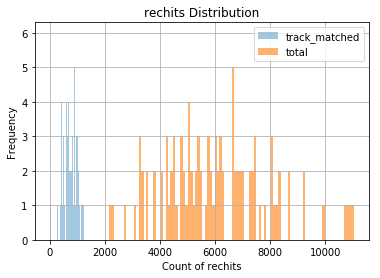

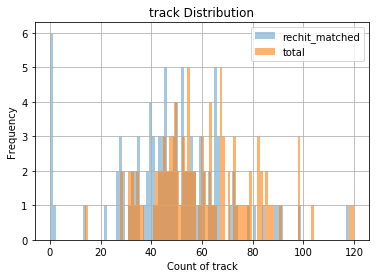

In [109]:
plot_matched_vs_unmatched(rechit_count_, ["track_matched", "total"], 'rechits')
plot_matched_vs_unmatched(track_count_, ["rechit_matched", "total"], 'track')

## Compare Track and Matched Rechit Eta

In [110]:
%%time

'''
Calculate the difference in track and rechit eta per event
Note: Gets Rechit Eta Values from Rechit Global DF
'''

# lists of delta-eta between tracks and matched rechits indexed by global_track_id
# also contains the mean of these values stored in a separate array using index 'mean_difference'
matched_track_eta_difference_ = {}

for event_id_ in range(number_of_events_):
    #event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    # iterate over the selected tracks and the rechit ids matched to each track
    matched_track_eta_difference_[event_id_] = {}
    for track_id_ in track_ids_['rechit_matched'][event_id_]:
        trk_eta_diff_ = []
        track_id_ = int(track_id_)
        # Retrieve eta for the track
        trk_eta_ = track_param_global_df_.iloc[track_id_]['track_eta']
        rechit_ids_for_track_ = track_global_df_.iloc[track_id_]['rechit_ids']
        for rechit_id_ in rechit_ids_for_track_:
            rechit_id_ = int(rechit_id_)
            trk_eta_diff_.append(trk_eta_ - rechit_param_global_df_.iloc[rechit_id_]['rechit_eta'])
        matched_track_eta_difference_[event_id_][track_id_] = trk_eta_diff_
    matched_track_eta_difference_[event_id_]['mean_difference'] = [sum(diff_list_)/len(diff_list_) for diff_list_ in matched_track_eta_difference_[event_id_].values()] 
    


CPU times: user 12.3 s, sys: 31 ms, total: 12.4 s
Wall time: 12.3 s


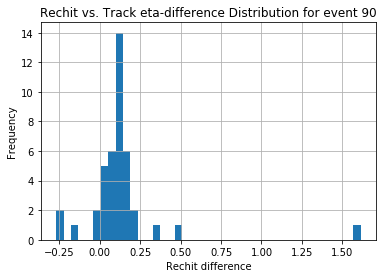

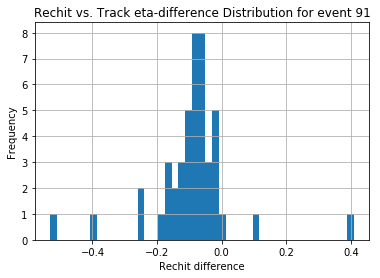

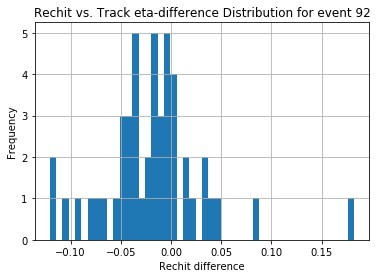

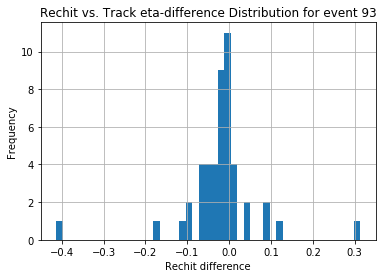

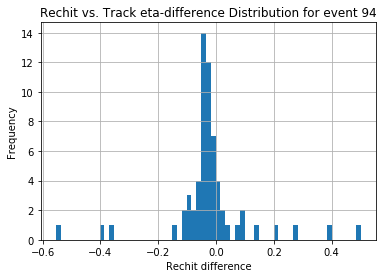

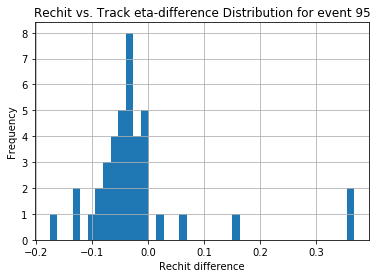

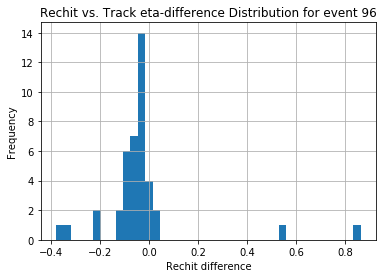

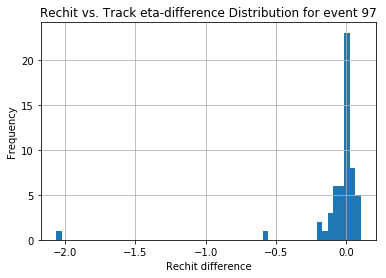

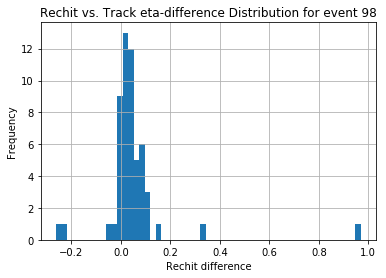

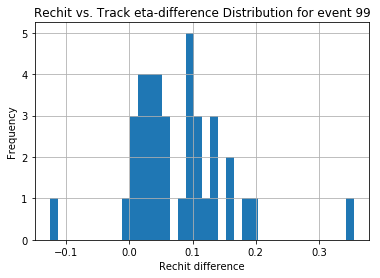

In [111]:
'''
Visualize the Difference in Eta between tracks and rechits belonging to the same track.
Repeat for SPECIFIED NUMBER OF events in the dataset.
'''

# TODO: Try to make this an aminated single graph constantly updating
# Issue: Matplotlib has problems with 'inline' and 'notebook' 
# (interactive plots) used in the same Jupyter Notebook

# plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('alpha', ['0.2', '0.4', '0.6', '0.8'])))
# print (rechit_param_global_df_.iloc[:50]['rechit_eta'])

for event_id_ in range(len(matched_track_eta_difference_.keys())-10, len(matched_track_eta_difference_.keys())):
    if len(matched_track_eta_difference_[event_id_]['mean_difference']) == 0:
        continue
    ax_ = plt.subplot()
    ax_.hist(matched_track_eta_difference_[event_id_]['mean_difference'], histtype='stepfilled', 
             bins=len(matched_track_eta_difference_[event_id_]['mean_difference']), 
             orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    plt.xlabel('Rechit difference')
    plt.title('Rechit vs. Track eta-difference Distribution for event ' + str(event_id_))
    #plt.savefig('plots/' + gen_event_ + '/track/' + key + 'tracks')
    plt.show()
    #plt.pause(2)
    

## Plot Track Parameters

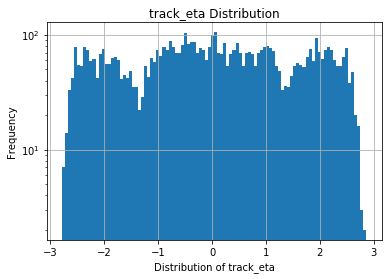

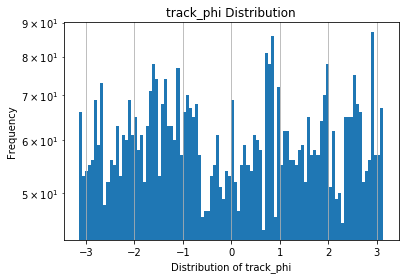

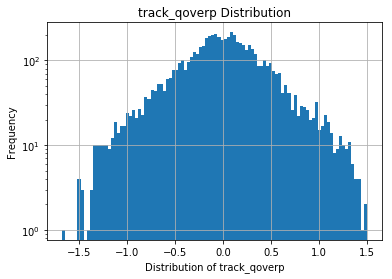

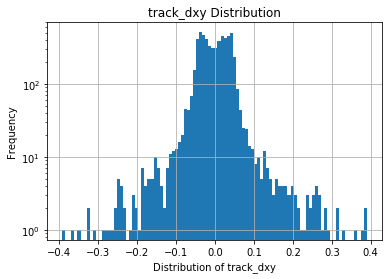

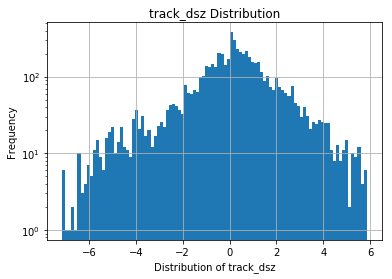

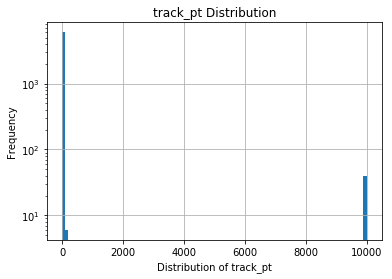

In [112]:
%matplotlib inline
# Iterate over 5 track parameters and plot their distribution
# Note: THIS IS LOG SCALE

for key in track_param_global_df_.columns:
    if key == 'track_id':
        continue
    ax_ = plt.subplot()
    ax_.hist(track_param_global_df_[key], histtype='stepfilled', bins=100, orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    
    # Comment the next line for a linear scale
    plt.yscale('log')
    
    plt.xlabel('Distribution of ' + key)
    plt.title(key + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key)
    plt.show()

### Filter High-Pt Events

Iterating over track pt from 6041 tracks


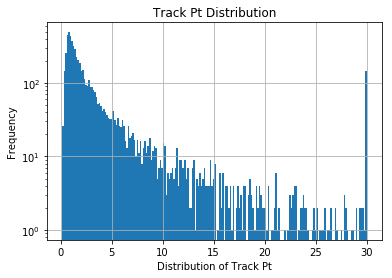

In [113]:
# Additional visualization discarding high-pt events for more clarity

track_pt_ = data_.array('trackPt')
concat_track_pt_ = []
high_pt_events_ = {}

for event_ in range(len(track_pt_)):
    high_pt_events_[event_] = 0
    for trk_pt_val_ in track_pt_[event_]:
        
        # What is a reasonable general threshold for Track Pt?
        if trk_pt_val_ < 30:
            concat_track_pt_.append(trk_pt_val_)
        else:
            high_pt_events_[event_] += 1
            concat_track_pt_.append(30)
            
print ("Iterating over track pt from", len(concat_track_pt_), "tracks")

plt.clf()
ax_ = plt.subplot()
ax_.hist(concat_track_pt_, histtype='stepfilled', bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.yscale('log')
plt.xlabel('Distribution of Track Pt')
plt.title('Track Pt Distribution')
plt.savefig('plots/' + gen_event_ + '/track/track-pt')
plt.show()

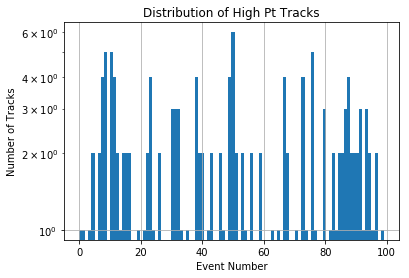

In [115]:
# Events with high pt tracks and their distribution
plt.clf()
ax_ = plt.subplot()
ax_.hist(list(high_pt_events_.keys()), weights=list(high_pt_events_.values()), bins=len(high_pt_events_.keys()), orientation='vertical')
plt.grid(True)
plt.ylabel('Number of Tracks')
plt.yscale('log')
plt.xlabel('Event Number')
plt.title('Distribution of High Pt Tracks')
plt.savefig('plots/' + gen_event_ + '/track/high-pt-events')
plt.show()


# Plot SimHit Distribution in X and Y Axes

In [116]:
%matplotlib inline

def plot_2d_rechit_parameters(params_, rechit_type_, n_bins_=300, figsize_x_=10, figsize_y_=10, uncut_rechit_ids_=None):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i: str

    :rtype: None 
    '''
    # Add updates to filter uncut Rechit IDs
    if uncut_rechit_ids_ is not None:
        print ("Method not defined to filter by uncut ids")
    else:
        x_coordinate_ = data_.array(params_[0])
        y_coordinate_ = data_.array(params_[1])

        if len(x_coordinate_) == len(y_coordinate_):
            concat_x_ = []
            concat_y_ = []

            for i in range(len(x_coordinate_)):
                concat_x_.extend(x_coordinate_[i])
                concat_y_.extend(y_coordinate_[i])

        plt.figure(figsize=(figsize_x_, figsize_y_))
        ax_ = plt.subplot(1,1,1)
        plt.xlabel(params_[0])
        plt.ylabel(params_[1])
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + ' Distribution')
        ax_.patch.set_facecolor('black')
        ax_.hist2d(concat_x_, concat_y_, bins=n_bins_, norm=matplotlib.colors.LogNorm(), cmap='hot')
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/2drechitdistribution')
        plt.show()
    return

In [117]:
%matplotlib inline
'''
Function to plot the rechit parameters as a histogram
'''
def plot_rechit_parameters(params_, rechit_type_, n_bins_=50, figsize_x_=8, figsize_y_=6):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i_: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i_: str

    :rtype: None 
    '''
    # Define a loop that plots R, Phi, and Eta for Rechits
    for property_ in params_:
        param_array_ = data_.array(property_)
        concat_param_array_ = []

        for i in range(len(param_array_)):
                concat_param_array_.extend(param_array_[i])

        plt.clf()
        fig, ax_ = plt.subplots(figsize=(figsize_x_, figsize_y_))
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + 'Rechit Distribution of ' + property_)
        ax_.hist(concat_param_array_, bins=n_bins_, histtype='stepfilled', align='mid', orientation='vertical', density=True)
        plt.xlabel('Value of ' + property_)
        plt.ylabel('Distribution of ' + property_)
        plt.title(property_ + ' Distribution')
        plt.grid(True)
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/' + property_)
        plt.show()
    return

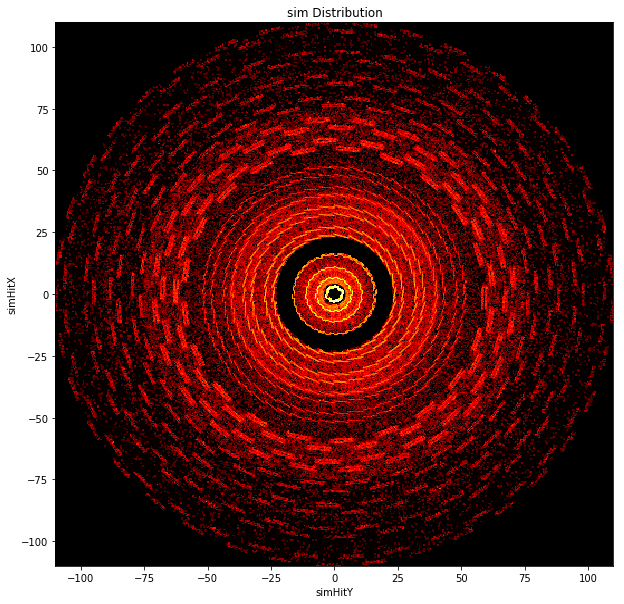

In [118]:
plot_2d_rechit_parameters(["simHitY", "simHitX"], 'sim', n_bins_=500)

### Count Simhits Matched to Tracks

In [119]:
%%time
'''
Extract the Simhits Matched to Tracks already from the C++ code
'''

# Count the simhit matches to tracks
simhit_tp_match_ = data_.array("simHitMatch")
simhit_count_ = {'track_matched': [], 'total': []}

for event_id_ in range(number_of_events_):
    match_count_ = 0
    for tp_ in simhit_tp_match_[event_id_]:
        # Change this to == 0 in the next set of ttbar outfiles
        if tp_ > 0:
            match_count_ += 1
        else:
            continue
    simhit_count_['total'].append(len(simhit_tp_match_[event_id_]))
    simhit_count_['track_matched'].append(match_count_)

count_total_ = []
count_matched_ = []
print ("Event, Total Hit Count, Matched Hit Count")

for i in range(number_of_events_):
    count_total_.append(simhit_count_['total'][i])
    count_matched_.append(simhit_count_['track_matched'][i])
    if simhit_count_['track_matched'][i] == 0:
        print (i, "\t", simhit_count_['total'][i], "\t", simhit_count_['track_matched'][i])

print (float(sum(count_matched_))/float(sum(count_total_)))

Event, Total Hit Count, Matched Hit Count
7 	 472505 	 0
8 	 714058 	 0
10 	 446368 	 0
29 	 464284 	 0
77 	 205020 	 0
88 	 529569 	 0
0.002792733728530752
CPU times: user 1min 16s, sys: 378 ms, total: 1min 16s
Wall time: 1min 17s


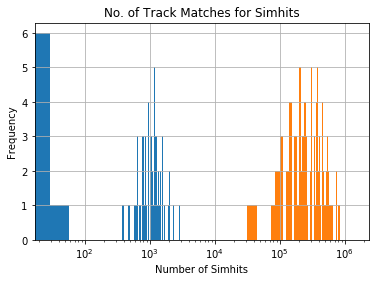

In [120]:
plt.clf()
ax_ = plt.subplot()
ax_.hist(simhit_count_['track_matched'], bins=len(simhit_count_['track_matched']), orientation='vertical', label='track_matched simhits')
ax_.hist(simhit_count_['total'], bins=len(simhit_count_['total']), orientation='vertical', label='track_matched simhits')
plt.grid(True)
plt.ylabel('Frequency')
plt.xlabel('Number of Simhits')
plt.xscale('log')
plt.title('No. of Track Matches for Simhits')
#plt.savefig('plots/' + gen_event_ + '/simhit/track-matches')
plt.show()

### Plot the Hole in the Data (2D Plot; 3D Axes)

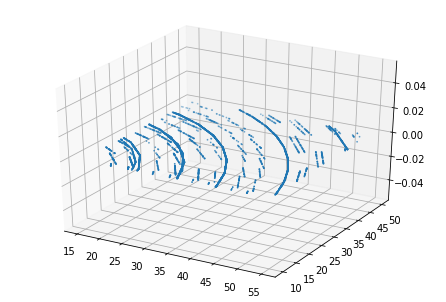

In [121]:
%matplotlib inline

# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?
fig_ = plt.figure()
ax_ = Axes3D(fig_)

mono_x_ = data_.array('monoHitX')
mono_y_ = data_.array('monoHitY')
mono_z_ = data_.array('monoHitZ')

concat_mono_x_ = []
concat_mono_y_ = []
concat_mono_z_ = []

for event_ in range(10):
    for x, y, z, in zip(mono_x_[event_], mono_y_[event_], mono_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_mono_x_.append(x)
            concat_mono_y_.append(y)
            concat_mono_z_.append(z)   

ax_.scatter3D(concat_mono_x_, concat_mono_y_, s=0.6)
#ax_.scatter3D(concat_mono_x_, concat_mono_y_, concat_mono_z_, s=0.6)

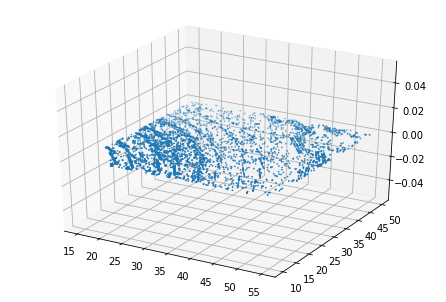

In [122]:
%matplotlib inline

# These are the SIMHITS lying along the same cross-section
# Clearly there is no hole in the Simhits

fig_ = plt.figure()
ax_ = Axes3D(fig_)

simhit_x_ = data_.array('simHitX')
simhit_y_ = data_.array('simHitY')
simhit_z_ = data_.array('simHitZ')

concat_simhit_x_ = []
concat_simhit_y_ = []
concat_simhit_z_ = []

for event_ in range(8):
    for x, y, z, in zip(simhit_x_[event_], simhit_y_[event_], simhit_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_simhit_x_.append(x)
            concat_simhit_y_.append(y)
            concat_simhit_z_.append(z)   

ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, s=0.6)  # Better visualization
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

### Visualize the Mono Rechits

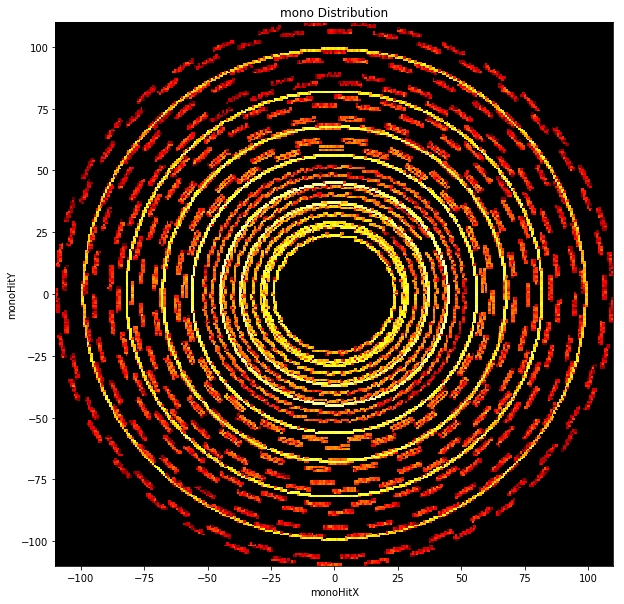

In [130]:
plot_2d_rechit_parameters(["monoHitX", "monoHitY"], 'mono')

## Plot Rechit Parameters

<Figure size 432x288 with 0 Axes>

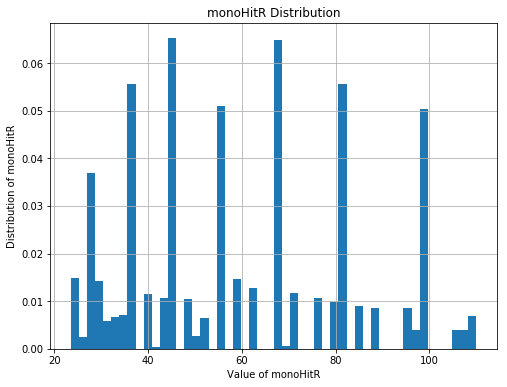

<Figure size 432x288 with 0 Axes>

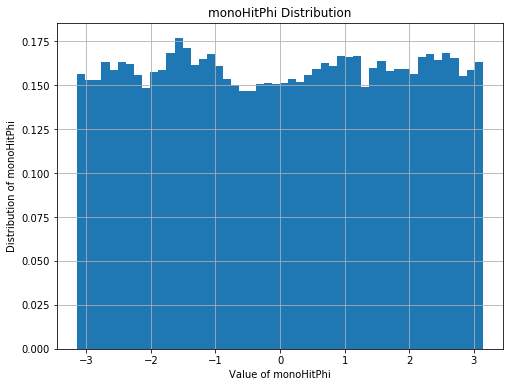

<Figure size 432x288 with 0 Axes>

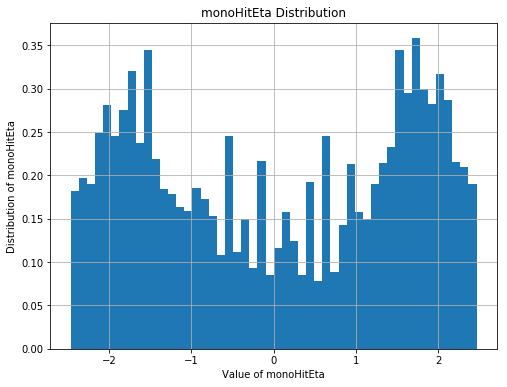

In [124]:
# Call the plot function to plot histograms of rechit parameters
plot_rechit_parameters(["monoHitR", "monoHitPhi", "monoHitEta"], 'mono')

## Visualize the Stereo Rechits

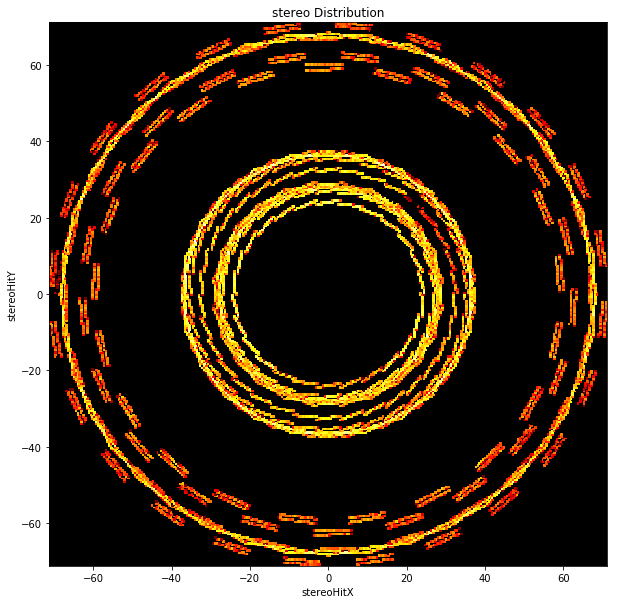

In [131]:
plot_2d_rechit_parameters(["stereoHitX", "stereoHitY"], 'stereo')

<Figure size 432x288 with 0 Axes>

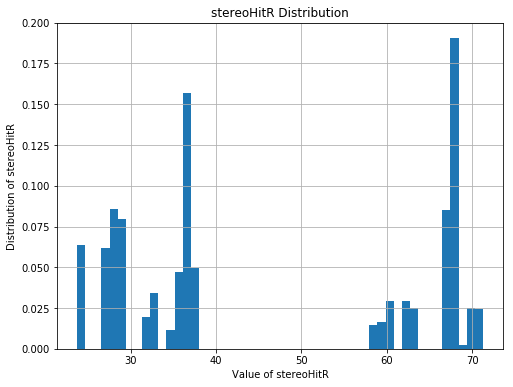

<Figure size 432x288 with 0 Axes>

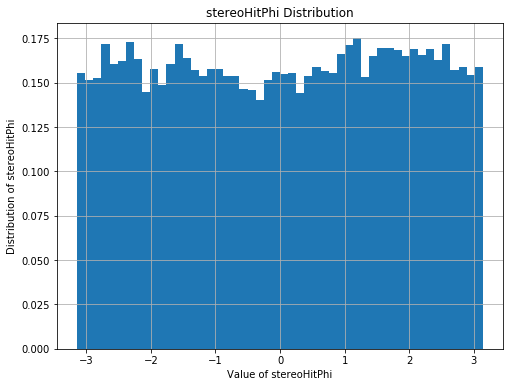

<Figure size 432x288 with 0 Axes>

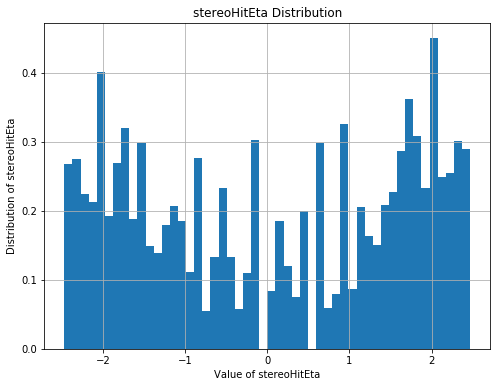

In [126]:
# Plot R, Phi, and Eta for Stereo Hits
plot_rechit_parameters(["stereoHitR", "stereoHitPhi", "stereoHitEta"], 'stereo')


### Testing Integrity of internal data storage 

In [127]:
%%time
# Correlate the above data to confirm the dataframe is correct
# TODO: Delete above code block as it takes too much time
hit_tp_count_ = {}

for id_, tp_idx_list_ in rechit_global_df_["rechit_tp_index"].items():
    tp_len_ = len(tp_idx_list_)
    if tp_len_ in hit_tp_count_:
        hit_tp_count_[tp_len_] += 1
    else:
        hit_tp_count_[tp_len_] = 1
print (hit_tp_count_)

{1: 429164, 0: 166358, 2: 4501, 3: 253, 4: 42, 8: 2, 5: 13, 6: 6, 9: 4, 7: 4}
CPU times: user 273 ms, sys: 11.9 ms, total: 285 ms
Wall time: 252 ms


## Store Data as Serialized DataFrames

In [128]:
import msgpack

ModuleNotFoundError: No module named 'msgpack'

In [ ]:
%%time
'''
Writing to serialized format fails in case of copied dataframes as the columns are sets

Solution: Iterate over all Global DataFrames, find the columns to replace, 
and replace with lists instead of sets so that they are serializable
'''

i = 0
# List of strings with dataframe names to set as filenames for storage
name_list_ = ['track_global_df_', 'track_param_global_df_', 'rechit_global_df_', 'rechit_param_global_df_']

for dataframe_ in [track_global_df_, track_param_global_df_, rechit_global_df_, rechit_param_global_df_]:
    dataframe_to_update_ = dataframe_.copy(deep=True)
    columns_to_replace_ = ['rechit_ids', 'rechit_tp_index', 'track_tp_index', 'track_matches']
    for column_name_ in columns_to_replace_:    
        if column_name_ in dataframe_to_update_:
            list_arr_ = []
            for set_ in dataframe_to_update_[column_name_]:
                list_arr_.append(list(set_))
            dataframe_to_update_.update(pd.Series(list_arr_, name=column_name_))
    filename_ = 'data/' + name_list_[i] + '.msgpack'
    dataframe_to_update_.to_msgpack(filename_)
    i += 1


In [ ]:
'''
Write the dictionaries containing matched/unmatched rechit/track data to CSV files
'''

#names_of_csv_files_ = ['data/track_count_.csv', 'data/rechit_count_.csv', 
                       #'data/track_ids_.csv', 'data/rechit_ids_.csv']    
#dicts_to_csv_ = [track_count_, rechit_count_, track_ids_, rechit_ids_]
#for i in range(len(names_of_csv_files_)):    

pd.DataFrame.from_dict(track_count_).to_csv('data/track_count_.csv')
pd.DataFrame.from_dict(rechit_count_).to_csv('data/rechit_count_.csv')
pd.DataFrame.from_dict(track_ids_).to_csv('data/track_ids_.csv')
pd.DataFrame.from_dict(rechit_ids_).to_csv('data/rechit_ids_.csv')

In [ ]:
import csv
with open('data/track_count_.csv', 'w') as csvFile:
    writer = csv.DictWriter(csvFile)
    writer.writerows(track_count_)
    
with open('data/rechit_count_.csv', 'w') as csvFile:
    writer = csv.DictWriter(csvFile)
    writer.writerows(rechit_count_)

with open('data/track_ids_.csv', 'w') as csvFile:
    writer = csv.DictWriter(csvFile)
    writer.writerows(track_ids_)

with open('data/rechit_ids_.csv', 'w') as csvFile:
    writer = csv.DictWriter(csvFile)
    writer.writerows(rechit_ids_)

## Convert to Adjacency Matrix for each Track

In [ ]:
import tensorflow as tf

In [ ]:

for event_id_ in range(number_of_events_):
    
    # Obtain subset of global dataframe for the respective event
    event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    tf.data.Dataset()
    

In [ ]:
criteria_ = [(len(rechit_id_list_) > 0) for rechit_id_list_ in track_global_df_['rechit_ids']]
track_matched_hit_ids_ = track_global_df_[criteria_]


In [ ]:
len(track_matched_hit_ids_)

In [ ]:
sum(track_count_['rechit_matched']) + sum(track_count_['tp_matched'])

In [ ]:
print (track_count_['rechit_matched'][3])
print (len(track_tp_idx_[3]))